## Aprendizado Multiobjetivo em Modelos Supervisionados

**Dupla**: Beatriz Evelyn Dalfior (22.1.8012), Amanda Jacomette Dias Barbosa (22.1.8025)

**Disciplina**: Aprendizagem de Máquina (CSI704)

**Professor**: Luiz Carlos Bambirra Torres


**Objetivos**:
- Implementar e treinar modelos supervisionados (Redes Neurais, Árvores de Decisão e Random Forest).
- Aplicar conceitos de otimização multiobjetivo para equilibrar erro de predição e complexidade do modelo.
- Compreender os trade-offs entre desempenho e complexidade.
- Demonstrar domínio da metodologia aplicada por meio de arguição.


---

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_circles, make_classification

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


---

### 1. Base de Dados:
Escolher três base de dados de regressão ou classificação do repositório UCI Machine Learning Repository (https://archive.ics.uci.edu/) ou outra fonte confiável.

Datasets:
- **Regressão**: Student Performance
- **Classificação**: Spambase
- Concrete Compressive Strength

In [14]:
# ------------------ STUDENT PERFORMANCE ------------------
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 

# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 
  
# metadata 
print(student_performance.metadata) 
  
# variable information 
print(student_performance.variables) 


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

---

### 2. Modelagem com Algoritmos Supervisionados:
Utilizar os três ou mais
- Rede Neural (MLP)
- Árvore de Decisão
- Random Forest

Explorar diferentes arquiteturas ou configurações (como profundidade, número de neurônios, número de árvores etc.) para gerar modelos com diferentes graus de complexidade.

In [30]:
# ------------------------- Preprocess dataset -------------------------
# Juntar X e y primeiro para garantir consistência
df = pd.concat([X, y], axis=1)

# Verificar quais colunas realmente existem no DataFrame
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

# Definir colunas categóricas esperadas
expected_cat_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus',
    'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

# Filtrar apenas as colunas que existem no DataFrame
cat_cols = [col for col in expected_cat_cols if col in df.columns]

print("\nColunas categóricas que serão codificadas:")
print(cat_cols)

# Verificar e tratar valores faltantes
print("\nValores faltantes antes do tratamento:")
print(df.isnull().sum())

# Preencher valores faltantes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

# Aplicar one-hot encoding apenas nas colunas categóricas existentes
df = pd.get_dummies(df, columns=cat_cols)

# Separar novamente X e y após o tratamento
X = df.drop(columns=y.columns)
y = df[y.columns]
# Verificar consistência no tamanho
print("\nNúmero de amostras em X e y:")
print(len(X), len(y))

df.head()

Colunas disponíveis no DataFrame:
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no', 'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no', 'higher_yes', 'internet_no', 'internet_yes', 'romantic_no', 'romantic_yes', 'G1', 'G2', 'G3']

Colunas categóricas que serão codificadas:
[]

Valores faltantes antes do tratamento:
age                  0
Medu                 0
Fedu                 0
traveltime       

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_5212\962257801.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,G1,G2,G3
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,True,False,True,False,0,11,11
1,17,1,1,1,2,0,5,3,3,1,...,False,False,True,False,True,True,False,9,11,11
2,15,1,1,1,2,0,4,3,2,2,...,True,False,True,False,True,True,False,12,13,12
3,15,4,2,1,3,0,3,2,2,1,...,True,False,True,False,True,False,True,14,14,14
4,16,3,3,1,2,0,4,3,2,1,...,True,False,True,True,False,True,False,11,13,13


In [40]:
# ------------------- Train/Test split -------------------
feat = ['Walc', 'absences', 'studytime' , 'G1', 'G2']
features = df[feat]
target = df['G3']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

# Verificar shapes após split
print("\nShapes após train/test split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Verificar se há valores NaN
print("\nValores NaN em X_train:", X_train.isna().sum().sum())
print("Valores NaN em y_train:", y_train.isna().sum().sum())


Shapes após train/test split:
X_train: (454, 5), y_train: (454,)
X_test: (195, 5), y_test: (195,)

Valores NaN em X_train: 0
Valores NaN em y_train: 0


---

### 3. Critérios de Avaliação:
**Erro de predição**: utilizar métricas como MSE, RMSE, acurácia, F1-score, conforme o tipo de problema.

**Complexidade do modelo**:
* **Redes neurais**: número de parâmetros treináveis.
* **Árvores de decisão**: profundidade ou número de nós.
* **Random Forest**: número de árvores e profundidade média.

In [41]:
# ------------------------- Random Forest Regressor -------------------------
# Verificar e garantir que y_train seja 1D
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.values.ravel()

RFR = RandomForestRegressor(random_state=100, criterion='squared_error', 
                          max_depth=30, min_samples_leaf=5, n_jobs=1)

# Train the regression
RFR.fit(X_train, y_train)
# Predict on the testing data
y_pred = RFR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nResultados do Modelo:")
print("RFR Mean Squared Error MSE:", mse)
print("RFR Root Mean Squared Error RMSE:", rmse)
print("RFR R^2 Score:", r2)


Resultados do Modelo:
RFR Mean Squared Error MSE: 1.4588831278079009
RFR Root Mean Squared Error RMSE: 1.2078423439372792
RFR R^2 Score: 0.868071633930986


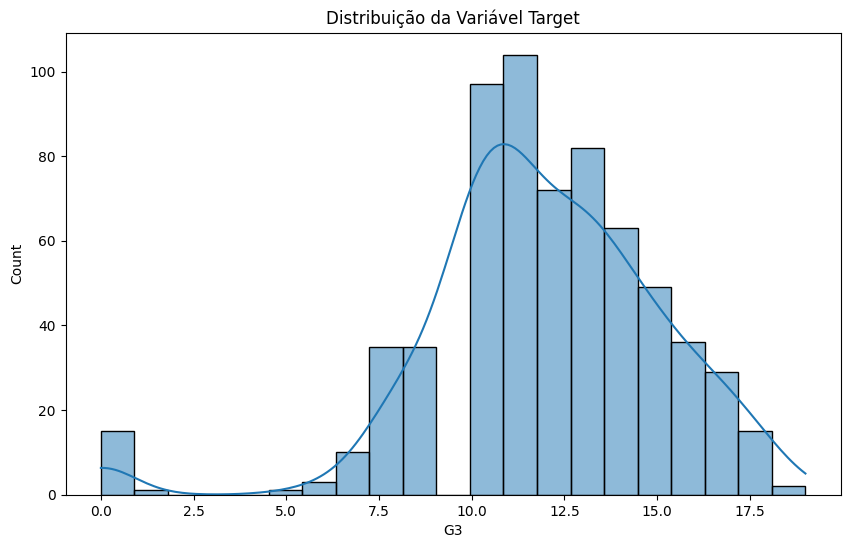

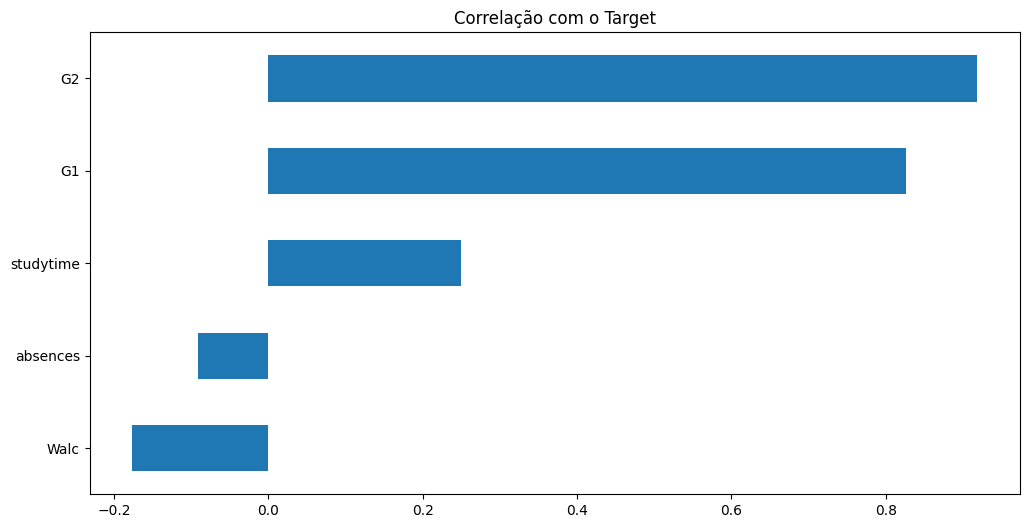

In [ ]:
# Verificar distribuição do target
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True) # y.iloc[:, 0]
plt.title('Distribuição da Variável Target')
plt.show()

# Correlação entre features numéricas e target
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_features].corrwith(target)
plt.figure(figsize=(12, 6))
correlations.sort_values().plot.barh()
plt.title('Correlação com o Target')
plt.show()

In [ ]:
# ------------------------- Decision Tree Regressor -------------------------
DTR = DecisionTreeRegressor(random_state=100, criterion='squared_error', max_depth=30, min_samples_leaf=5)

# Train the regression
DTR.fit(X_train, y_train)

# Predict on the testing data
y_pred = DTR.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = sqrt(mse)

r2 = r2_score(y_test, y_pred)

print("DTR Mean Squared Error MSE:", mse)
print("DTR Root Mean Squared Error RMSE:", rmse)
print("DTR R^2 Score:", r2)

---

### 4. Otimização Multiobjetivo:
Utilizar alguma abordagem para encontrar modelos que equilibrem desempenho e complexidade, como:
- Busca em grade ou aleatória com análise biobjetiva.
- Algoritmos evolutivos (como NSGA-II, se desejado).
- Análise e visualização da fronteira de Pareto.